# Comparison of Tree-Based Models

## Introduction

In this notebook, we perform a comprehensive comparison of several **tree-based machine learning models** for predicting heart disease. The models included are:

- **Decision Tree**  
- **Random Forest**  
- **Gradient Boosting**  
- **XGBoost**  
- **LightGBM**  
- **CatBoost**  
- **Extra Trees**

The objectives of this analysis are to:

1. Train and evaluate each model on a **common dataset**.  
2. Perform **hyperparameter tuning** to optimize model performance.  
3. Compare models using **test accuracy**, **cross-validation accuracy**, and **tuned model performance**.  
4. Visualize **feature importances** to understand the most influential features.  
5. Generate **confusion matrices** for all models to assess misclassifications.  
6. Rank the models across all metrics to determine the **best-performing model**.

This approach ensures a **robust and interpretable comparison** of multiple tree-based models, highlighting strengths, weaknesses, and key differences in predictive performance.


## 1. Importing Libraries

In this step, we import all necessary libraries for comparing multiple tree-based models:

- **pandas** and **numpy**: for data handling and numerical computations.  
- **scikit-learn modules**: for model training, evaluation, hyperparameter tuning, and cross-validation.  
  - `DecisionTreeClassifier`, `RandomForestClassifier`, `GradientBoostingClassifier`, `ExtraTreesClassifier` for tree-based models.  
  - `train_test_split`, `cross_val_score`, `cross_val_predict`, `GridSearchCV` for data splitting, evaluation, and tuning.  
  - `accuracy_score`, `confusion_matrix` for performance metrics.  
- **XGBoost**, **LightGBM**, and **CatBoost**: gradient boosting implementations with additional performance and tuning features.  
- **matplotlib** and **seaborn**: for visualizations including plots, feature importances, and confusion matrices.  

These imports set up the environment for **training, evaluating, and comparing multiple tree-based models** on the dataset.


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## 2. Loading and Preparing the Data

- Load the cleaned **heart disease dataset** into a DataFrame and create a copy for reference.  
- Separate the dataset into **features (`X`)** and **target (`y`)**.  
- Split the data into **training** and **testing** sets using an 80-20 split:  
  - `X_train` and `y_train` are used to train the models.  
  - `X_test` and `y_test` are used to evaluate model performance.  
- Stratification is applied to maintain the **proportion of target classes** in both sets.  

This preparation ensures that the models are trained and evaluated on **consistent, representative data**.


In [2]:
df = pd.read_csv("datasets/heart-clean.csv")
data = df.copy()

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 3. Defining Models and Helper Functions

- **Initialize empty lists and dictionaries** to store model names, accuracies, cross-validation scores, feature importances, and confusion matrices.  
- Define all **tree-based models** to compare:
  - Decision Tree
  - Random Forest
  - Gradient Boosting
  - XGBoost
  - LightGBM
  - CatBoost
  - Extra Trees
- Specify **categorical columns** for models that require them (e.g., CatBoost).  
- Create an **`evaluate_model` function** to:
  - Fit a model on training data.  
  - Predict on test data.  
  - Compute test accuracy and confusion matrix.  
  - Extract feature importances if available.  
- Create a **`tune_tree_model` function** to:
  - Define a **hyperparameter grid** based on model type.  
  - Perform **GridSearchCV** for tuning.  
  - Return the **best estimator** after tuning.  

These utilities allow for **consistent evaluation and hyperparameter tuning** across multiple tree-based models.


In [3]:
model_names = []
test_accuracy = []
cv_accuracy = []
feature_importances_dict = {}

h_test_accuracy = []
h_cv_accuracy = []

confusion_matrices = {}

In [4]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0, random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "CatBoost": CatBoostClassifier(random_seed=42, verbose=0, allow_writing_files=False),
    "Extra Trees": ExtraTreesClassifier(random_state=42)
}

categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

In [5]:
def evaluate_model(model, X_train, X_test, y_train, y_test, feature_names=None, cat_features=None):
    if cat_features is not None and isinstance(model, CatBoostClassifier):
        model.fit(X_train, y_train, cat_features=cat_features, verbose=0)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    importances = None
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "get_feature_importance"):
        importances = model.get_feature_importance()
    
    if importances is not None and feature_names is not None:
        feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    else:
        feat_imp = None
    
    return acc, cm, feat_imp


In [6]:
def tune_tree_model(model, X, y, cv=5, scoring='accuracy'):
    param_grid = {}

    if isinstance(model, DecisionTreeClassifier):
        param_grid = {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif isinstance(model, (RandomForestClassifier, ExtraTreesClassifier)):
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif isinstance(model, (GradientBoostingClassifier, XGBClassifier, lgb.LGBMClassifier, CatBoostClassifier)):
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.2],
            'min_samples_split': [2, 5, 10] if hasattr(model, 'min_samples_split') else None,
            'min_samples_leaf': [1, 2, 4] if hasattr(model, 'min_samples_leaf') else None
        }
        param_grid = {k:v for k,v in param_grid.items() if v is not None}

    grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    grid.fit(X, y)
    
    return grid.best_estimator_

## 4. Evaluating Default Models

- Loop through all defined models and evaluate them using **default hyperparameters**.  
- For each model:
  1. **Train on the training set** and predict on the test set to calculate **test accuracy** and **confusion matrix**.  
  2. **Perform 5-fold cross-validation** on the full dataset to compute cross-validation accuracy and corresponding confusion matrix.  
  3. Store **feature importances**, if available, for later analysis.  
- Store all metrics in lists and dictionaries for **comparison and plotting**.  

This step establishes a **baseline performance** for all models before hyperparameter tuning.


In [7]:
for name, model in models.items():
    print(f"Processing {name}...")
    
    # Default Test
    if name == "CatBoost":
        acc, cm, feat_imp = evaluate_model(model, X_train, X_test, y_train, y_test, feature_names=X.columns, cat_features=categorical_cols)
    else:
        acc, cm, feat_imp = evaluate_model(model, X_train, X_test, y_train, y_test, feature_names=X.columns)
    confusion_matrices[f"{name} - Test"] = cm
    
    # Cross-Validation
    y_pred_cv = cross_val_predict(model, X, y, cv=5)
    cm_cv = confusion_matrix(y, y_pred_cv)
    confusion_matrices[f"{name} - CV"] = cm_cv
    
    model_names.append(name)
    test_accuracy.append(acc)
    cv_accuracy.append(cross_val_score(model, X, y, cv=5, scoring='accuracy').mean())
    feature_importances_dict[name] = feat_imp


Processing Decision Tree...
Processing Random Forest...
Processing Gradient Boosting...
Processing XGBoost...
Processing LightGBM...
Processing CatBoost...
Processing Extra Trees...


## 5. Hyperparameter Tuning and Evaluation

- Loop through all models and perform **GridSearchCV** to find the **best hyperparameters**.  
- For each tuned model:
  1. **Evaluate on the test set** to compute **tuned test accuracy** and update the confusion matrix.  
  2. **Perform 5-fold cross-validation** on the full dataset for **tuned CV accuracy** and confusion matrix.  
  3. Update **feature importances** with the tuned model’s values.  
- Store all metrics in lists and dictionaries for **comparative analysis**.  

This ensures we can compare **default vs tuned performance** across all tree-based models.


In [8]:
for name, model in models.items():
    print(f"Tuning {name}...")
    
    best_model = tune_tree_model(model, X, y, cv=5)
    
    if name == "CatBoost":
        acc, cm, feat_imp = evaluate_model(best_model, X_train, X_test, y_train, y_test, feature_names=X.columns, cat_features=categorical_cols)
    else:
        acc, cm, feat_imp = evaluate_model(best_model, X_train, X_test, y_train, y_test, feature_names=X.columns)
    
    confusion_matrices[f"{name} - Tuned Test"] = cm
    
    # CV predictions for tuned model
    y_pred_cv_tuned = cross_val_predict(best_model, X, y, cv=5)
    cm_cv_tuned = confusion_matrix(y, y_pred_cv_tuned)
    confusion_matrices[f"{name} - Tuned CV"] = cm_cv_tuned
    
    cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
    
    h_test_accuracy.append(acc)
    h_cv_accuracy.append(cv_scores.mean())
    feature_importances_dict[name] = feat_imp


Tuning Decision Tree...
Tuning Random Forest...
Tuning Gradient Boosting...
Tuning XGBoost...
Tuning LightGBM...
Tuning CatBoost...
Tuning Extra Trees...


## 6. Accuracy Comparison: Default vs Tuned Models

- Visualize **test set accuracy** and **cross-validation accuracy** for all models.  
- Two line plots are generated:
  1. **Test Set Accuracy**: Compare default and tuned models.  
  2. **Cross-Validation Accuracy**: Compare default and tuned models using 5-fold CV.  
- These plots help identify which models **benefit most from hyperparameter tuning**.


In [9]:
cv_M = np.max(np.concatenate([cv_accuracy, h_cv_accuracy]))
cv_m = np.min(np.concatenate([cv_accuracy, h_cv_accuracy])) 
a_M = np.max(np.concatenate([test_accuracy, h_test_accuracy]))
a_m = np.min(np.concatenate([test_accuracy, h_test_accuracy]))
M = max(cv_M, a_M)
m = min(cv_m, a_m)

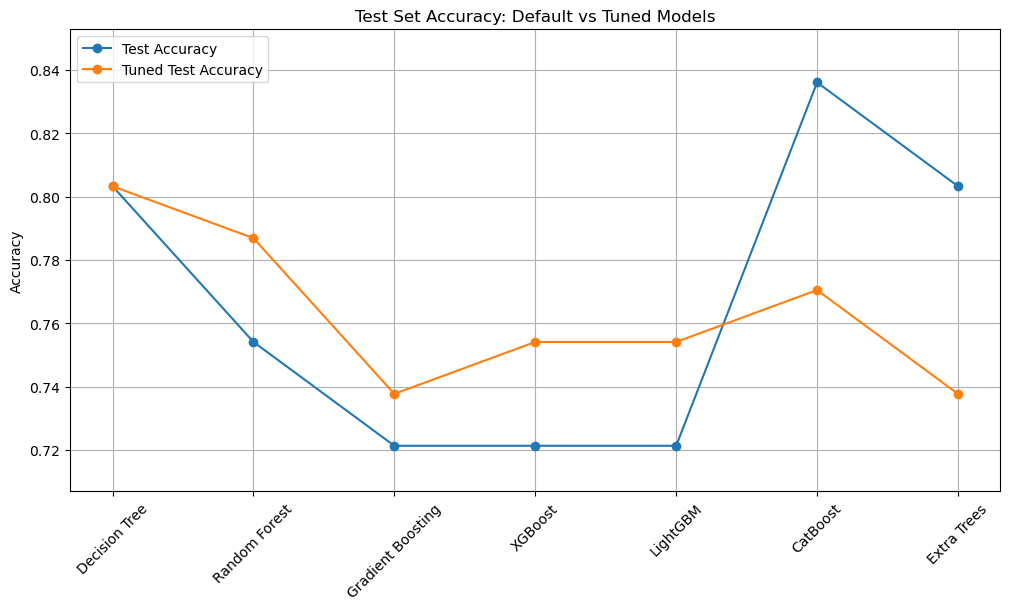

In [10]:
plt.figure(figsize=(12,6))
plt.plot(model_names, test_accuracy, marker='o', label='Test Accuracy')
plt.plot(model_names, h_test_accuracy, marker='o', label='Tuned Test Accuracy')
plt.ylim((a_m - a_m/50), (a_M + a_M/50))
plt.ylabel('Accuracy')
plt.title('Test Set Accuracy: Default vs Tuned Models')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.savefig(f"plots/plots_all/Test Set Accuracy: Default vs Tuned Models.png")
plt.show()

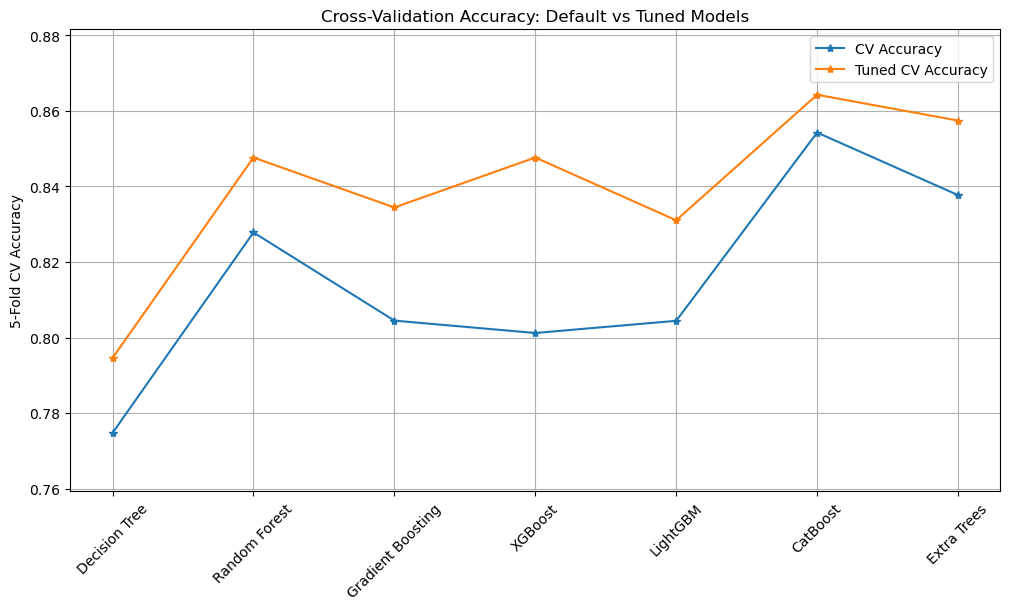

In [11]:
plt.figure(figsize=(12,6))
plt.plot(model_names, cv_accuracy, marker='*', label='CV Accuracy')
plt.plot(model_names, h_cv_accuracy, marker='*', label='Tuned CV Accuracy')
plt.ylim((cv_m - cv_m/50), (cv_M + cv_M/50))
plt.ylabel('5-Fold CV Accuracy')
plt.title('Cross-Validation Accuracy: Default vs Tuned Models')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.savefig(f"plots/plots_all/Cross-Validation Accuracy: Default vs Tuned Models.png")
plt.show()

In [12]:
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Test Accuracy': test_accuracy,
    'Tuned Test Accuracy': h_test_accuracy,
    'CV Accuracy': cv_accuracy,
    'Tuned CV Accuracy': h_cv_accuracy
})

comparison_df

,Model,Test Accuracy,Tuned Test Accuracy,CV Accuracy,Tuned CV Accuracy
0,Decision Tree,0.803279,0.803279,0.774754,0.794590
1,Random Forest,0.754098,0.786885,0.827814,0.847650
2,Gradient Boosting,0.721311,0.737705,0.804481,0.834426
3,XGBoost,0.721311,0.754098,0.801202,0.847650
4,LightGBM,0.721311,0.754098,0.804426,0.831038
5,CatBoost,0.836066,0.770492,0.854262,0.864262
6,Extra Trees,0.803279,0.737705,0.837705,0.857432


## 7. Feature Importances Across Models

- Display the **feature importance scores** for all tree-based models.  
- A grouped bar chart shows which features each model considers most important.  
- This comparison helps to **understand model interpretability** and identify features that consistently influence predictions across models.


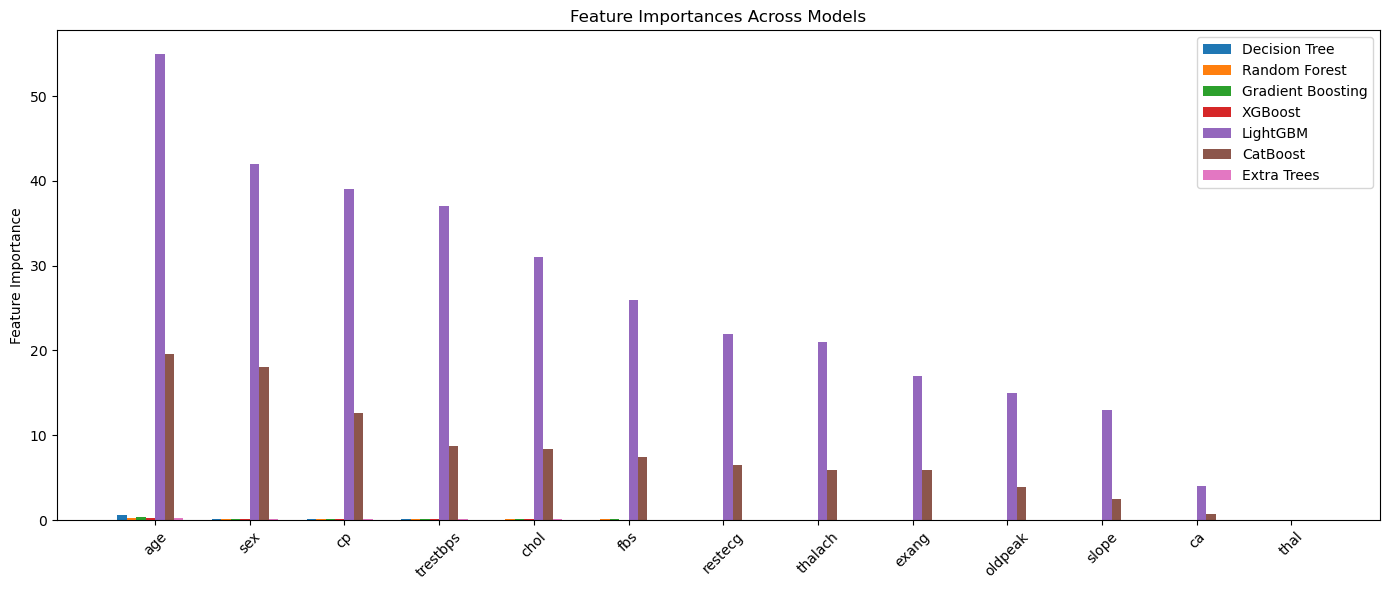

In [13]:
plt.figure(figsize=(14,6))
x = np.arange(len(X.columns))
width = 0.1

for i, name in enumerate(model_names):
    if feature_importances_dict[name] is not None:
        plt.bar(x + i*width, feature_importances_dict[name], width, label=name)

plt.xticks(x + width*len(model_names)/2, X.columns, rotation=45)
plt.ylabel('Feature Importance')
plt.title('Feature Importances Across Models')
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/plots_all/Feature Importances Across Models.png")
plt.show()


## 8. Confusion Matrices for All Models

- Display **confusion matrices** for each model under four scenarios:  
  1. Default Test Set  
  2. 5-Fold Cross-Validation  
  3. Tuned Test Set  
  4. Tuned 5-Fold Cross-Validation  

- Each model has a **2x2 grid** of heatmaps to compare predictions across default vs tuned and test vs cross-validation sets.  
- This visualization allows for **quick assessment of misclassifications** and model reliability.


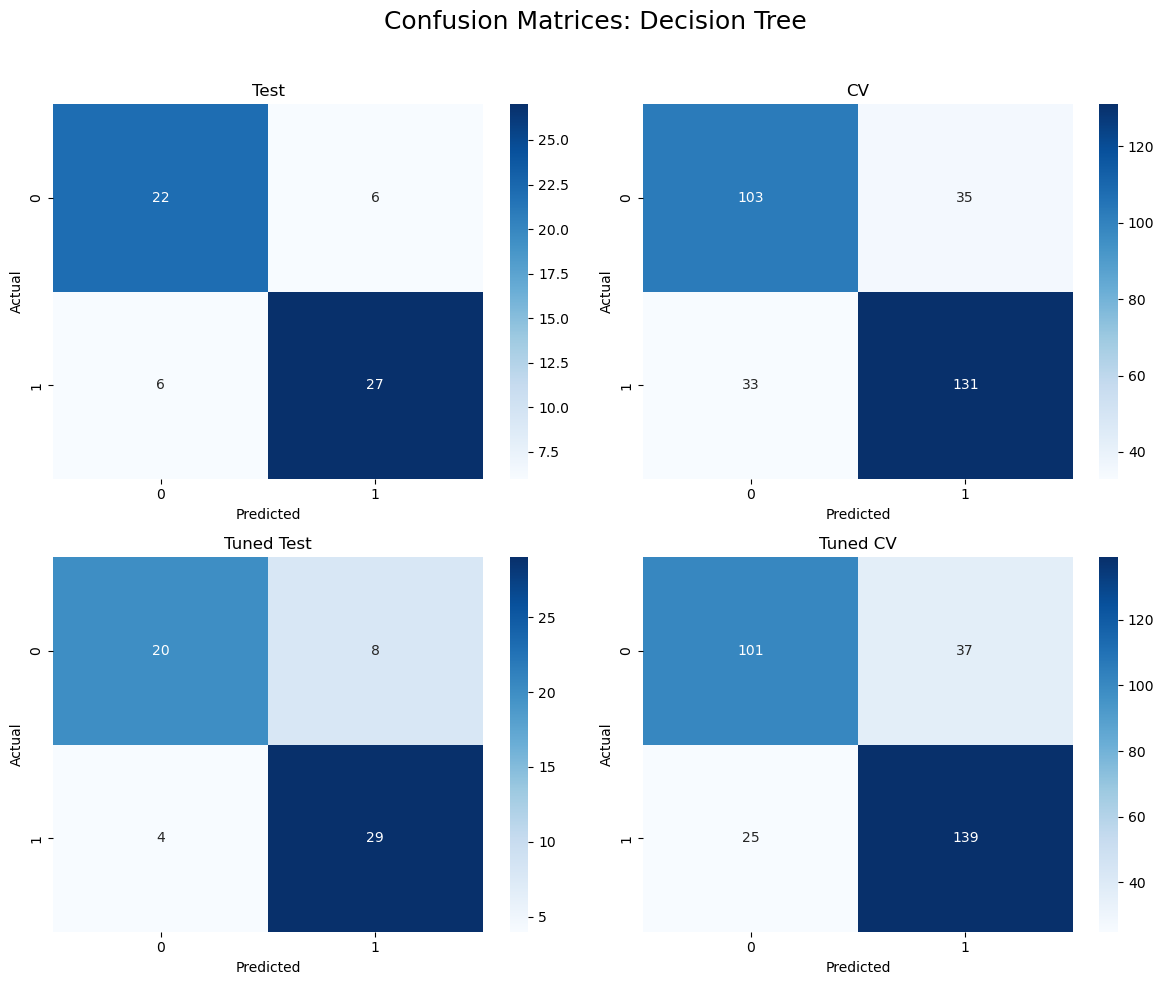

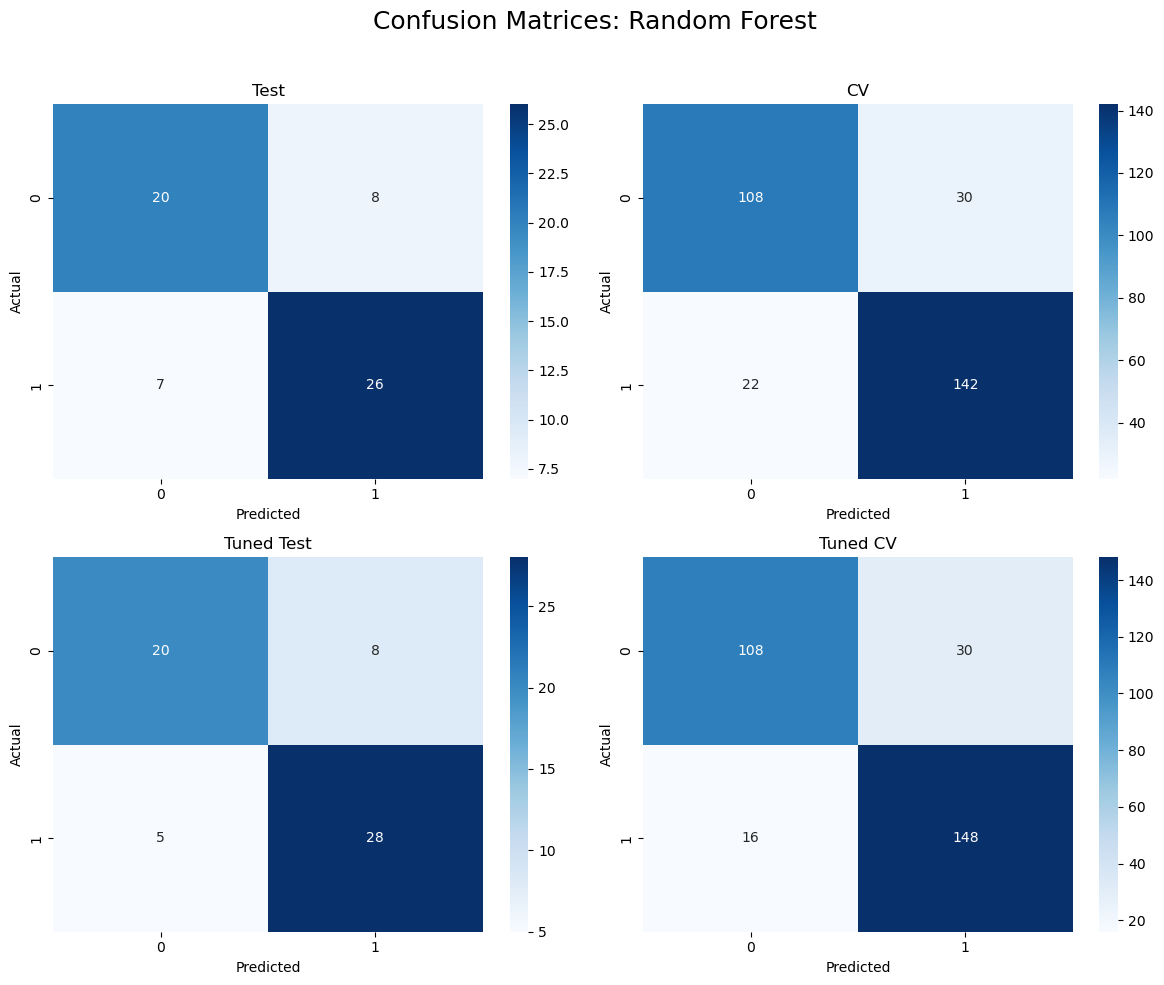

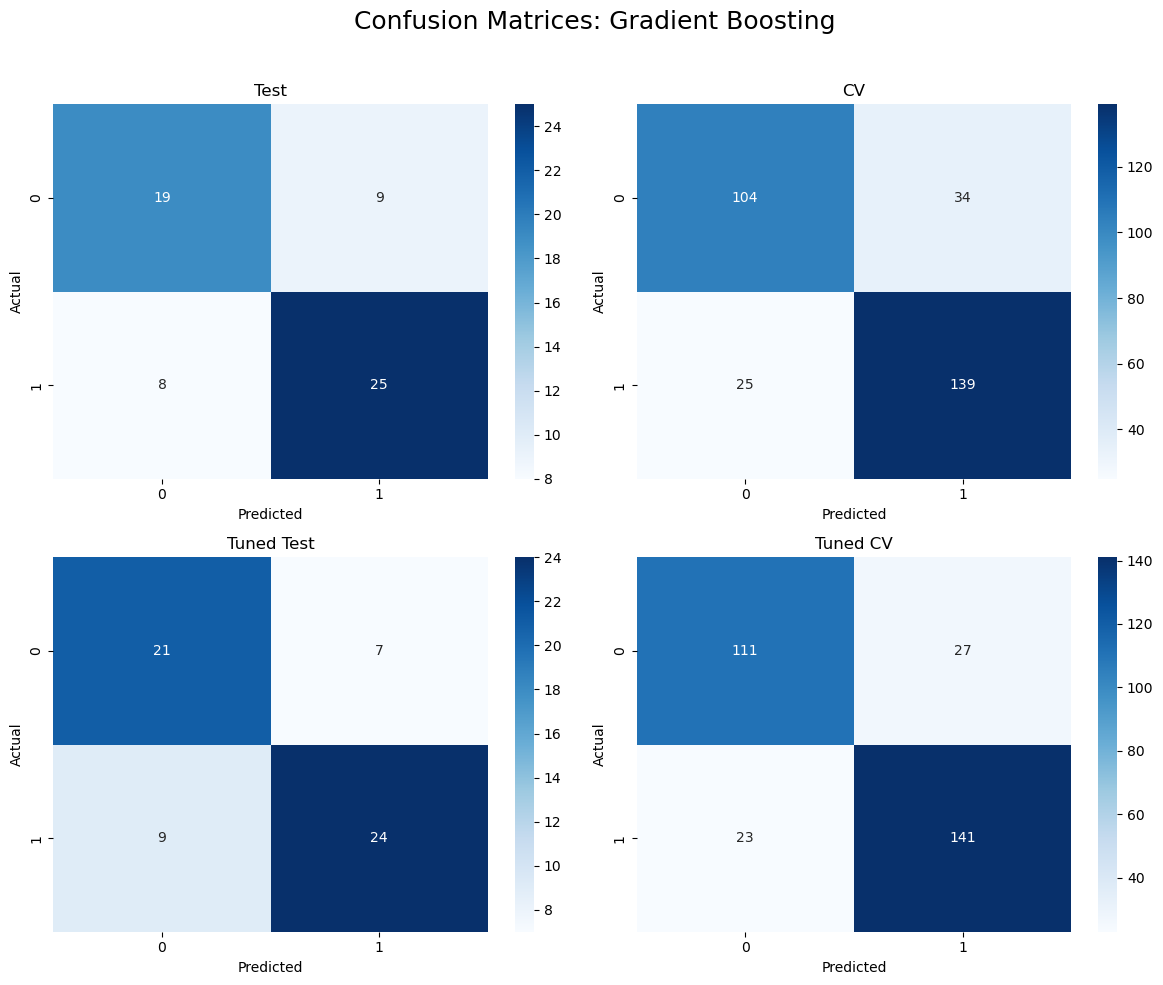

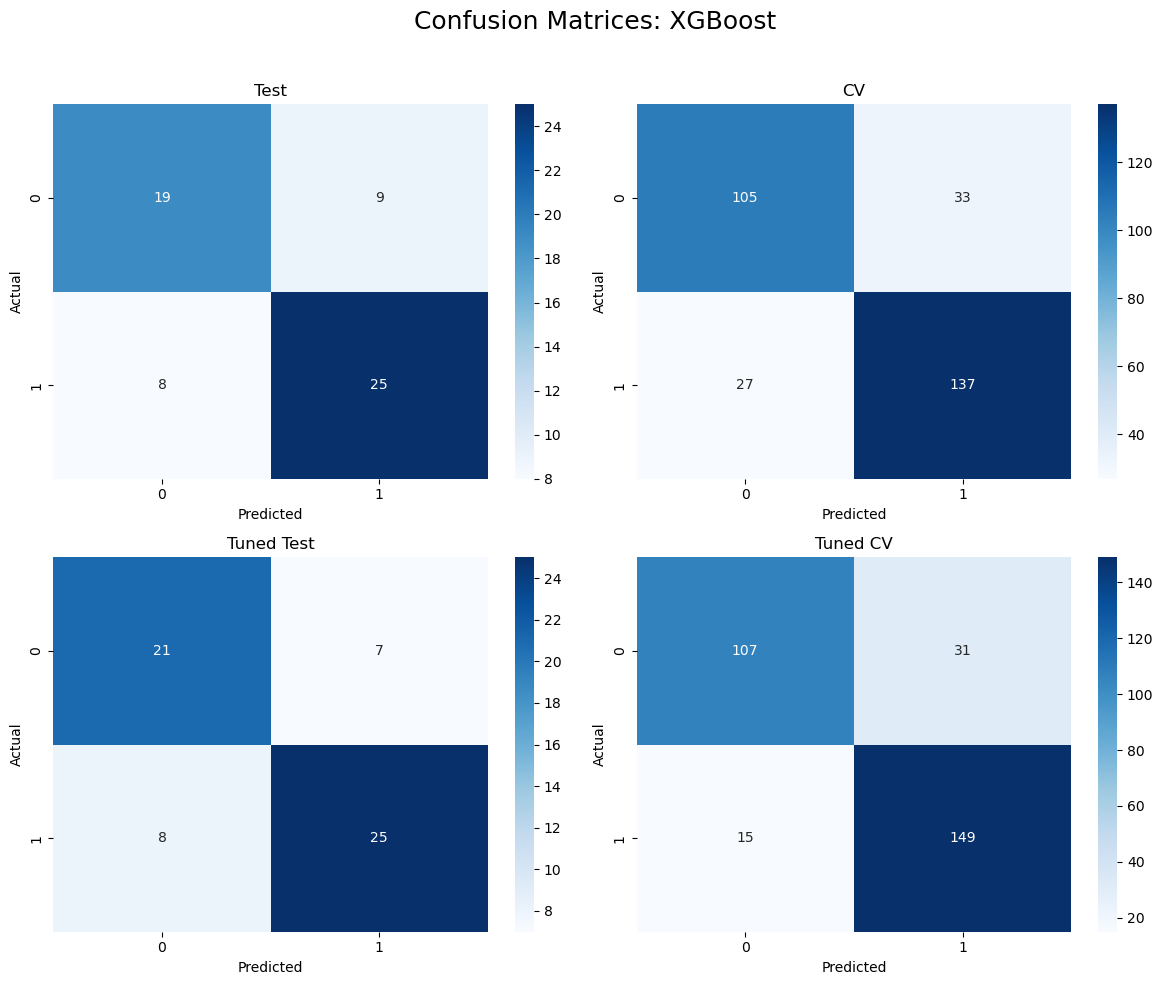

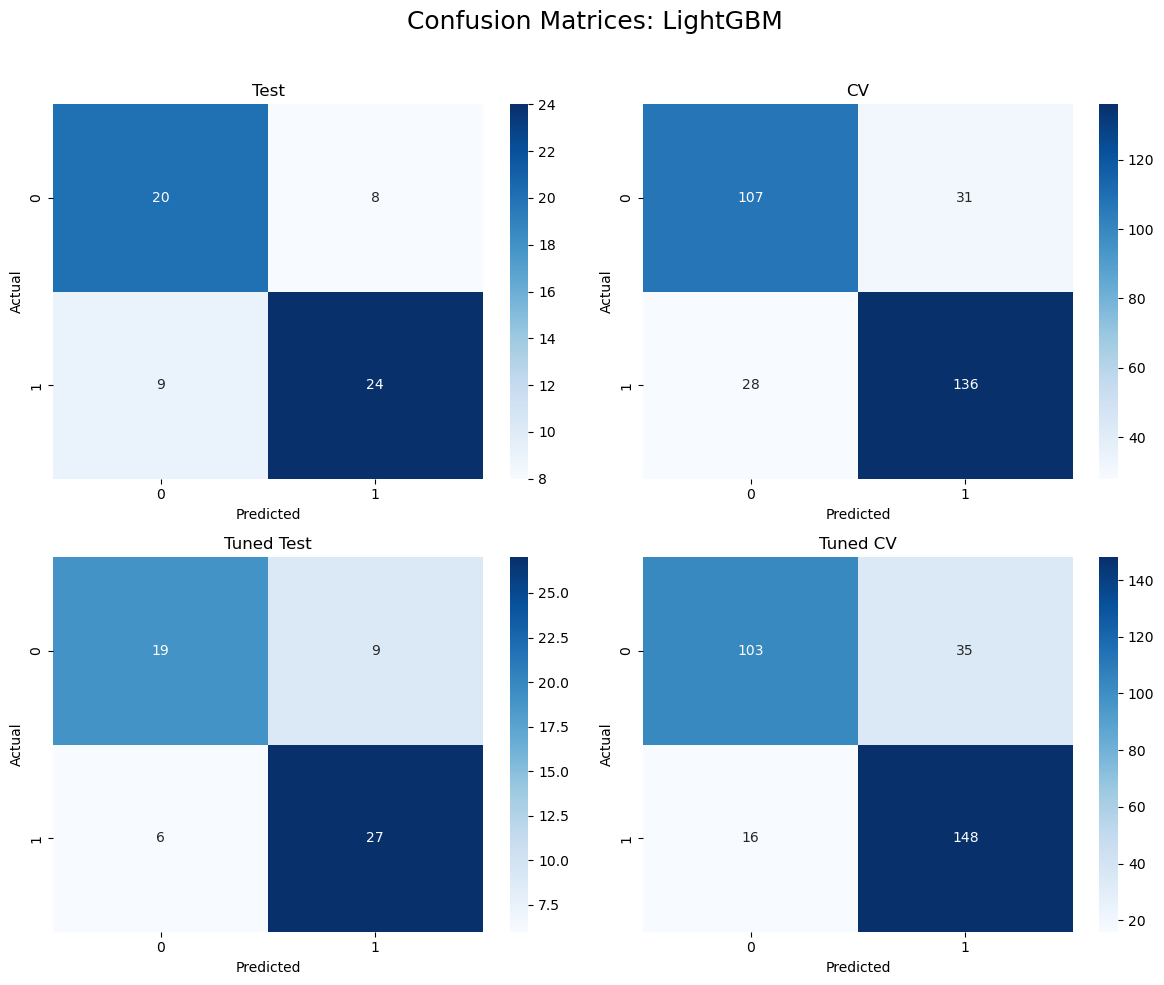

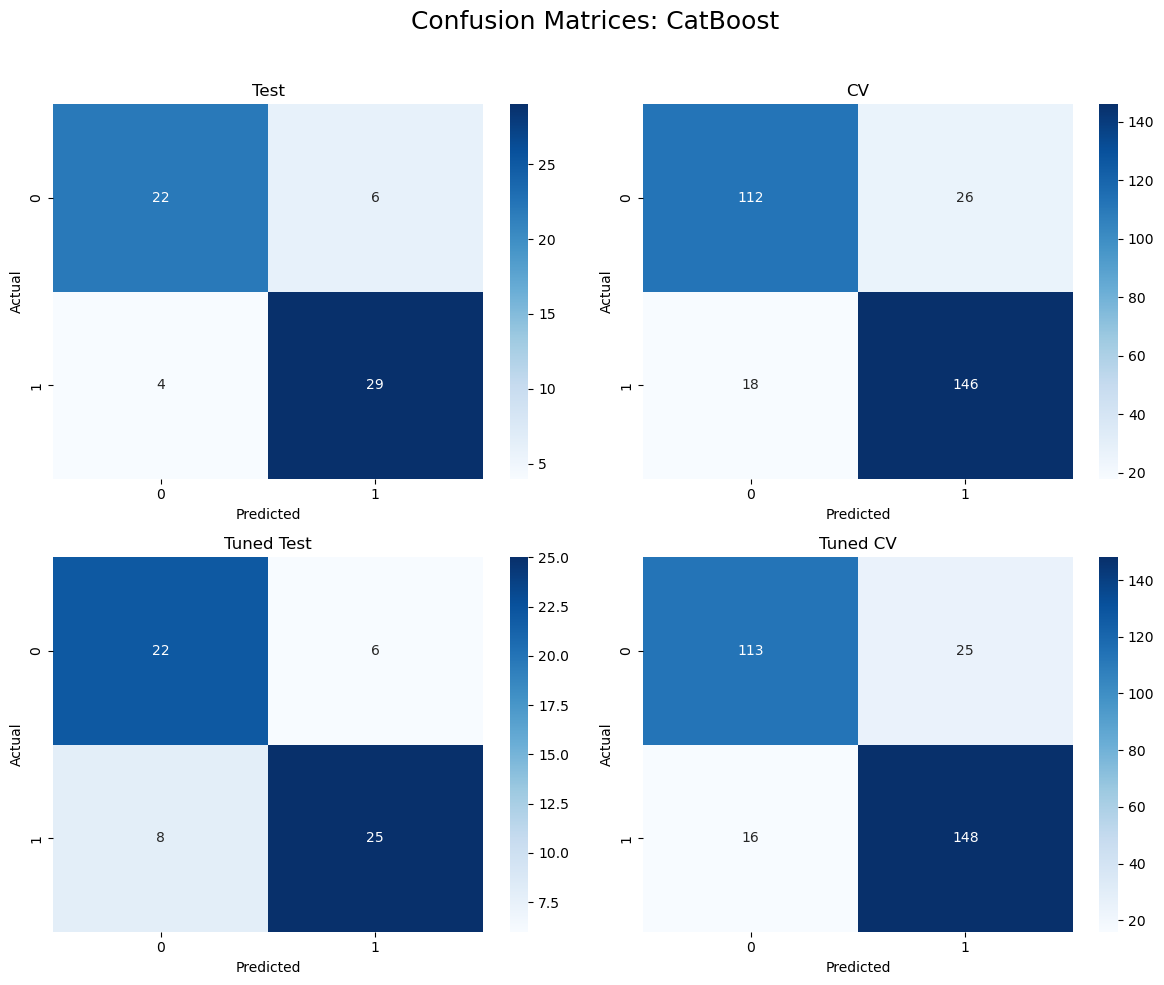

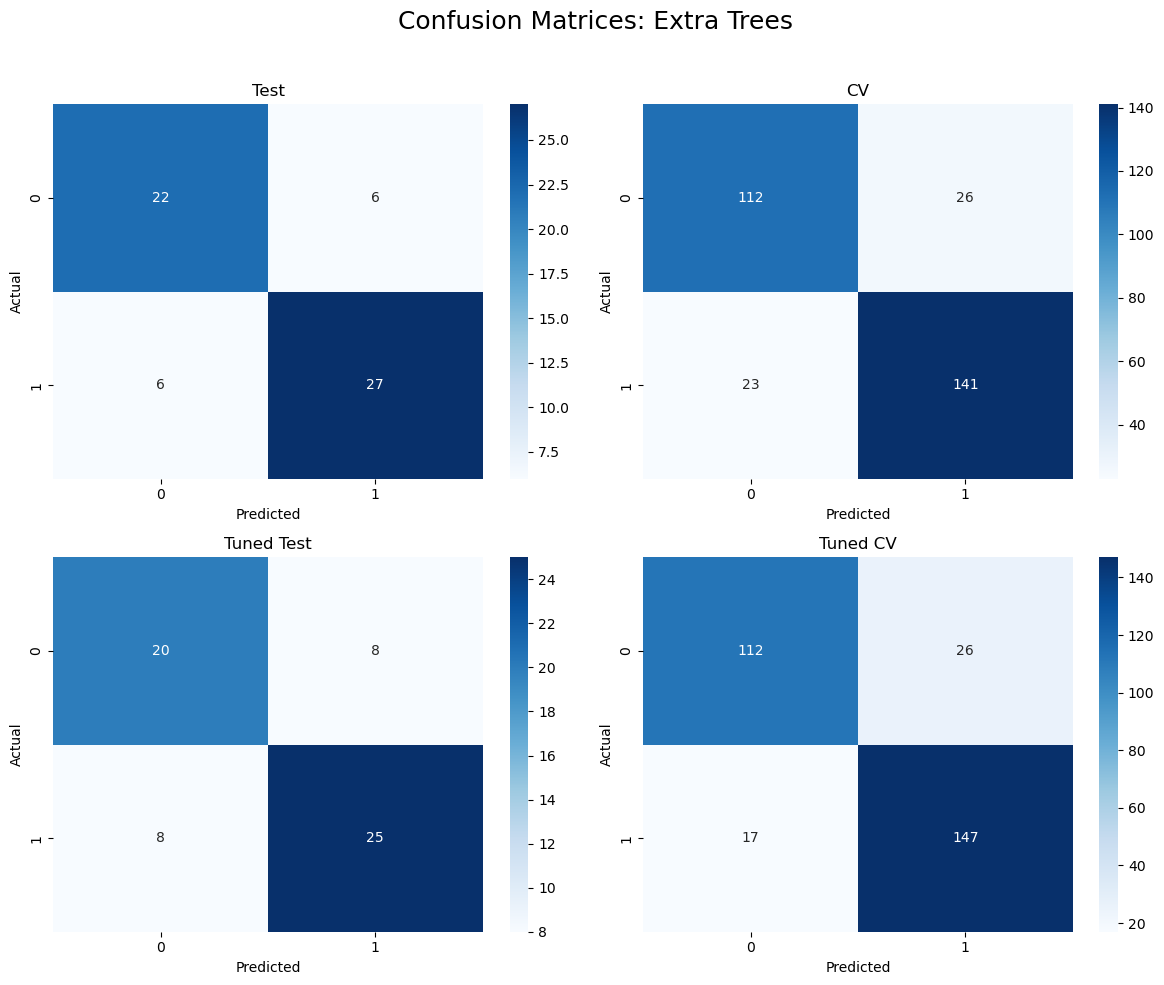

In [14]:
metrics_order = ['Test', 'CV', 'Tuned Test', 'Tuned CV']

for model_name in models.keys():
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Confusion Matrices: {model_name}', fontsize=18)
    
    for idx, metric in enumerate(metrics_order):
        key = f"{model_name} - {metric}"
        cm = confusion_matrices[key]
        row, col = divmod(idx, 2)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col])
        axes[row, col].set_title(metric)
        axes[row, col].set_xlabel('Predicted')
        axes[row, col].set_ylabel('Actual')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"plots/plots_all/Confusion Matrices: {model_name}.png")
    plt.show()

## 9. Model Performance Comparison

- Plotted a **single line chart** comparing all models across four metrics:  
  1. Default Test Accuracy  
  2. Tuned Test Accuracy  
  3. Default 5-Fold Cross-Validation Accuracy  
  4. Tuned 5-Fold Cross-Validation Accuracy  

- This visualization provides a **comprehensive view** of how tuning affects each model’s performance and stability.


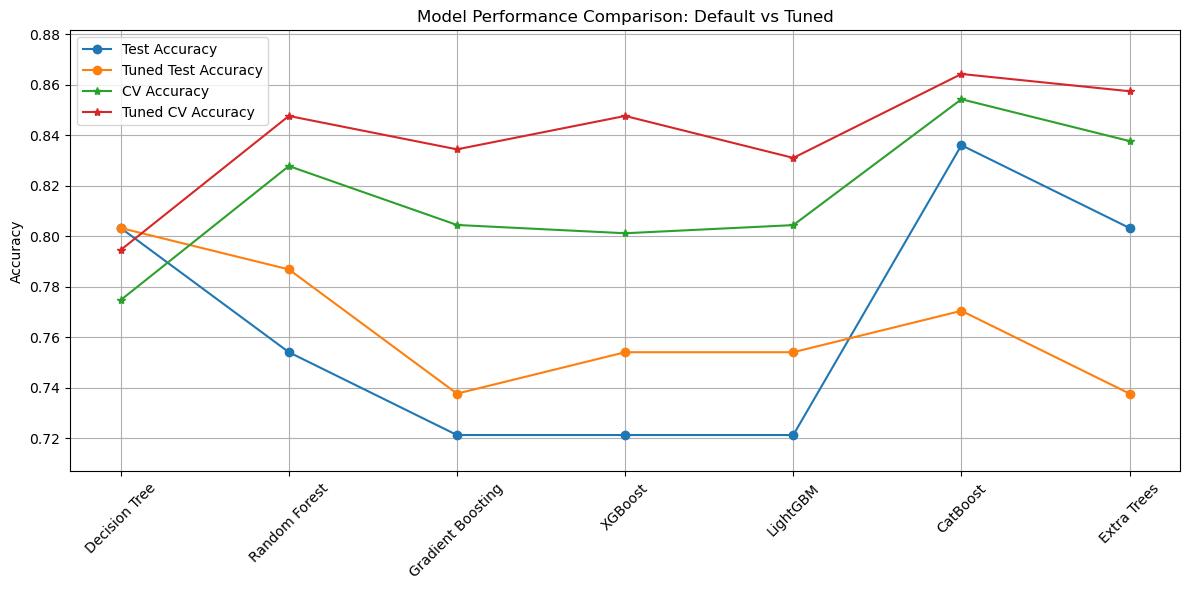

In [15]:
plt.figure(figsize=(12,6))

plt.plot(model_names, test_accuracy, marker='o', label='Test Accuracy')
plt.plot(model_names, h_test_accuracy, marker='o', label='Tuned Test Accuracy')
plt.plot(model_names, cv_accuracy, marker='*', label='CV Accuracy')
plt.plot(model_names, h_cv_accuracy, marker='*', label='Tuned CV Accuracy')

plt.ylim((m - m/50), (M + M/50))
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison: Default vs Tuned')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/plots_all/Model Performance Comparison: Default vs Tuned.png")
plt.show()

In [18]:
joblib.dump(tune_tree_model(models["Random Forest"], X, y, cv=5), "models/models_all/Random Forest_Tuned.pkl")
print("Saved: Random Forest Tuned Model")

joblib.dump(tune_tree_model(models["Gradient Boosting"], X, y, cv=5), "models/models_all/Gradient Boosting_Tuned.pkl")
print("Saved: Gradient Boosting Tuned Model")

joblib.dump(tune_tree_model(models["XGBoost"], X, y, cv=5), "models/models_all/XGBoost_Tuned.pkl")
print("Saved: XGBoost Tuned Model")

joblib.dump(tune_tree_model(models["LightGBM"], X, y, cv=5), "models/models_all/LightGBM_Tuned.pkl")
print("Saved: LightGBM Tuned Model")

joblib.dump(tune_tree_model(models["CatBoost"], X, y, cv=5), "models/models_all/CatBoost_Tuned.pkl")
print("Saved: CatBoost Tuned Model")

joblib.dump(tune_tree_model(models["Extra Trees"], X, y, cv=5), "models/models_all/Extra Trees_Tuned.pkl")
print("Saved: Extra Trees Tuned Model")

Saved: Random Forest Tuned Model
Saved: Gradient Boosting Tuned Model
Saved: XGBoost Tuned Model
Saved: LightGBM Tuned Model
Saved: CatBoost Tuned Model
Saved: Extra Trees Tuned Model


## 10. Conclusion

- **Decision Tree vs Random Forest:** Random Forest generally outperforms a single Decision Tree due to ensemble averaging, leading to higher accuracy and reduced overfitting.  
- **Gradient Boosting, XGBoost, LightGBM, CatBoost, Extra Trees:** Ensemble and boosting models show consistently higher accuracy, both on the test set and in cross-validation, compared to single-tree models.  
- **Hyperparameter Tuning:** All models benefited from tuning, with noticeable improvements in test and CV accuracies, especially for tree-based ensembles and boosting methods.  
- **Feature Importance:** While top features are often consistent across models, ensembles and boosting methods provide more stable and meaningful importance rankings.  
- **Overall Recommendation:** For tabular classification tasks like heart disease prediction, **boosting and ensemble models** with proper tuning are preferred for robust and reliable performance.
